### 1. Импортировать библиотеки в Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import scipy
import torch

torch.cuda.synchronize()
torch.cuda.empty_cache()

cuda = torch.device('cuda')

### 2. Загрузка и подготовка данных.

In [2]:
name = random.choice(os.listdir("dataset"))

name = 'testLab1Var7.csv'

print(f"Dataset: {name}")

dataset = np.genfromtxt(f"dataset/{name}", delimiter=',')

dataset = [dataset[:, i] for i in range(dataset.shape[1])]
title = ["time", "current", "voltage"]

dataset_dict = dict(zip(title, dataset))

Dataset: testLab1Var7.csv


### 3. Нарисовать графики тока и напряжения.

Для удобства отображения отображу не весь график, а некоторый его случайный диапазон заданного размера, установив лимиты на данные.

In [3]:
"""
Размер интервала
"""
time_period = 0.5

In [4]:
time_interval = random.random() * (dataset_dict["time"][-1] - time_period)
time_interval = (time_interval, time_interval + time_period)

print(f"Временной интервал {time_interval}")

Временной интервал (90.16691888920329, 90.66691888920329)


Text(0, 0.5, 'Сила Тока, А')

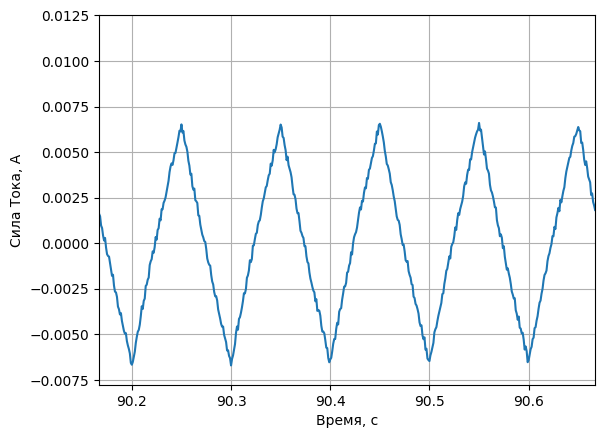

In [5]:
plt.plot(dataset_dict["time"], dataset_dict["current"])
plt.xlim(time_interval)
plt.grid()
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')

Text(0, 0.5, 'Напряжение, В')

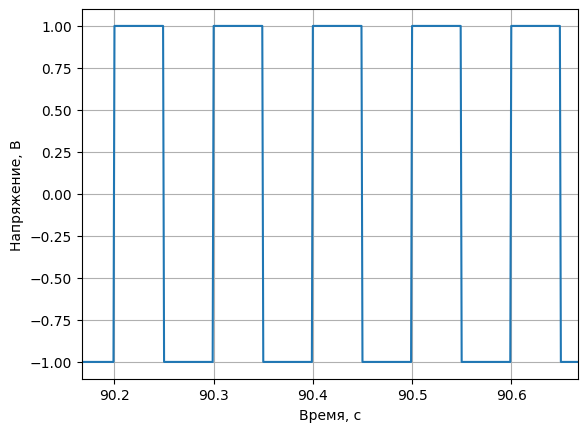

In [6]:
plt.plot(dataset_dict["time"], dataset_dict["voltage"])
plt.xlim(time_interval)
plt.grid()
plt.xlabel('Время, с')
plt.ylabel('Напряжение, В')

### 4. Рассчитать значения параметров L и R.

Упрощённая модель двигателя постоянного тока. Модель двигателя постоянного тока описывается следующей системой дифференциальных уравнений:

di/dt = 1 / L * u - R / L * i - Ce

dΩ/dt = Ce / J * i - 1 / J * Md

Y = K*X

I(k) = (Ts / L) * U(k-1) - ((R*Ts - L) / L) * I(k-1)

I(k) = K1 * U(k-1) + K2 * I(k-1)



In [7]:
# TODO: remove

torch.cuda.empty_cache()

# torch.tensor([1., 2.], device=cuda)

x = torch.randn(20000, 20000, device=cuda)
w = torch.randn(20000, 20000, device=cuda)

torch.mm(x, w)

del x
del w

torch.cuda.empty_cache()

In [8]:
X = np.transpose(np.concatenate([np.array([dataset_dict["voltage"], ]), np.array([dataset_dict["current"], ])], axis=0))

Y = np.transpose(np.array([dataset_dict["current"], ]))

In [9]:
# X : n*k
# K : k*1
# X * K = Y
# [U(k-1);I(k-1)] * K = [I(k)]

X = X[:-1, :]  # U(k-1);I(k-1)
Y = Y[1:, :]  # I(k)

print(X.shape)
print(Y.shape)

(100000, 2)
(100000, 1)


In [10]:
X_tensor = torch.tensor(X, device=cuda)
Y_tensor = torch.tensor(Y, device=cuda)

X_svd = torch.svd(X_tensor)

X_psi = X_svd.V
X_psi = torch.mm(X_psi, torch.diag(1 / X_svd.S))
X_psi = torch.mm(X_psi, X_svd.U.T)

"""
X_tensor_alt = X_svd.U
X_tensor_alt = torch.mm(X_tensor_alt, torch.diag(X_svd.S))
X_tensor_alt = torch.mm(X_tensor_alt, X_svd.V.T)
"""

print(X_psi)

tensor([[ 1.0018e-05,  9.9972e-06,  9.9773e-06,  ..., -9.4187e-06,
         -9.3804e-06, -9.3747e-06],
        [-1.1966e-04,  1.9203e-05,  1.5295e-04,  ..., -3.9209e-03,
         -4.1795e-03, -4.2179e-03]], device='cuda:0', dtype=torch.float64)


In [11]:
K_approx = torch.mm(X_psi, Y_tensor)
print(K_approx)

e2_Y = torch.mm(Y_tensor.T - torch.mm(X_tensor, K_approx).T, Y_tensor - torch.mm(X_tensor, K_approx))

print(e2_Y)

tensor([[2.6420e-04],
        [9.9339e-01]], device='cuda:0', dtype=torch.float64)
tensor([[0.0045]], device='cuda:0', dtype=torch.float64)


- $x + y$
- $x - y$
- $x \times y$
- $x \div y$
- $\dfrac{x}{y}$
- $\sqrt{x}$

In [12]:
"""
# X : n*k
# K : k*1

e2_Y : 1*1

e2_X : 1*k
e2_K : k*1

e2_Y = e2_X * K + X * e2_K

"""

# e2_Y = X * e2_K
# e2_K = subinv(X) * e2_Y

e2_K = torch.mm(e2_Y, X_psi)

print(e2_K)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 2x100000)

In [ ]:
# Y_est = K_est * X



In [ ]:
Td = 0.001

R = 1/K[0]*(1-K[1])
T = -Td / np.log(K[1])

L = T*R


print(L)

In [ ]:
Td = 0.001

R_est = []
L_est = []

if K[1] > 0:
    R = 1 / K[0] * (1 - K[1])
    T = -Td / np.log(K[1])
    R_est.append(R)
    L_est.append(T * R)

R_est = np.array(R_est)
L_est = np.array(L_est)

In [ ]:
print('Mean value of R: ', np.mean(R_est), ' Ohm')
print('Standart deviation of R: ', np.std(R_est))
print('Mean value of L = ', np.mean(L_est), ' Hn')
print('Standart deviation of R: ', np.std(L_est))

In [ ]:
# K1 = (Ts / L)
# L = Ts / K1
# K2 = - ((R*Ts - L) / L)
# K2 * L = L - R*Ts
# R*Ts = L - K2 * L
# R = (L - K2 * L) / Ts


L = Td / K[0]
R = (L - K[1] * L) / Td



print('R = ', R, ' Ohm')
print('L = ', L, ' Hn')